In [1]:
using JuMP
using Gurobi

In [2]:
type Arc
    initNode::Int 
    termNode::Int 
    capacity::Float64
    freeflowtime::Float64
    flow::Float64
    flow_car::Float64
    flow_truck::Float64
end

Arc(initNode::Int, termNode::Int, capacity::Float64,freeflowtime::Float64) = 
    Arc(initNode, termNode, capacity, freeflowtime, 0., 0., 0.)

Arc (constructor with 3 methods)

In [3]:
polyEval(coeffs, pt) = sum([coeffs[i] * pt^(i-1) for i = 1:length(coeffs)])  

polyEval (generic function with 1 method)

In [4]:
function facto(m::Int64)
    factori = 1
    for j = 1:m
        factori = factori * j
    end
    return factori
end

facto (generic function with 1 method)

In [5]:
function comb(n::Int64, m::Int64)
    combi = facto(n) / (facto(m) * facto(n-m))
    return int(combi)
end

comb (generic function with 1 method)

In [6]:
function setUpFitting(deg::Int64, c::Float64)
    
    normCoeffs = Array(Float64, deg+1)
    for i=1:deg + 1
        normCoeffs[i] = comb(deg, i-1) * c^(deg-i+1)
    end

	m = Model(solver=GurobiSolver(OutputFlag=false))
    
	@defVar(m, coeffs[1:deg+1])

	return m, coeffs, normCoeffs

end

setUpFitting (generic function with 1 method)

In [7]:
function addResid(m, coeffs, ys_car, ys_truck, demands_car, demands_truck, arcs, scaling)
	@defVar(m, resid)
    @defVar(m, dual_cost)
	@defVar(m, dual_cost_car)
    @defVar(m, dual_cost_truck)
	@defVar(m, primal_cost)
    @defVar(m, primal_cost_car)
    @defVar(m, primal_cost_truck)

	@addConstraint(m, dual_cost_car == sum{demands_car[(s,t)] * (ys_car[(s,t), t] - ys_car[(s,t), s]), (s,t)=keys(demands_car)})  
    @addConstraint(m, dual_cost_truck == sum{demands_truck[(s,t)] * (ys_truck[(s,t), t] - ys_truck[(s,t), s]), (s,t)=keys(demands_truck)})  
    @addConstraint(m, dual_cost == dual_cost_car + dual_cost_truck)
    
	@addConstraint(m, primal_cost_car == sum{a.flow_car * 1.0 * a.freeflowtime * polyEval(coeffs, a.flow/a.capacity), a=values(arcs)})
	@addConstraint(m, primal_cost_truck == sum{a.flow_truck * 1.1 * a.freeflowtime * polyEval(coeffs, a.flow/a.capacity), a=values(arcs)})
    @addConstraint(m, primal_cost == primal_cost_car + primal_cost_truck)
                   
	@addConstraint(m, resid >= (primal_cost - dual_cost) / scaling)
    @addConstraint(m, resid >= 0)
	return resid
end

addResid (generic function with 1 method)

In [8]:
function addIncreasingCnsts(m, coeffs, arcs)
	sorted_flows = sort([a.flow / a.capacity for a in values(arcs)])
	for i = 2:length(sorted_flows)
		@addConstraint(m, polyEval(coeffs, sorted_flows[i-1]) <= polyEval(coeffs, sorted_flows[i]))
	end
end

addIncreasingCnsts (generic function with 1 method)

In [9]:
function normalize(m, coeffs)
    @addConstraint(m, coeffs[1] == 1)
end

normalize (generic function with 1 method)

In [10]:
function addNetworkCnsts(m, coeffs, demands_car, demands_truck, arcs, numNodes)
	@defVar(m, ys_car[keys(demands_car), 1:numNodes])
    @defVar(m, ys_truck[keys(demands_truck), 1:numNodes])
	for k = keys(arcs)
		a = arcs[k]
		rhs = a.freeflowtime * polyEval(coeffs, a.flow/a.capacity)
		for od in keys(demands_car)
			@addConstraint(m, ys_car[od, k[2]] - ys_car[od, k[1]] <= 1.0 * rhs)
		end
		for od in keys(demands_truck)
			@addConstraint(m, ys_truck[od, k[2]] - ys_truck[od, k[1]] <= 1.1 * rhs)
		end
	end
	return ys_car, ys_truck
end

addNetworkCnsts (generic function with 1 method)

In [11]:
##########
#Fitting Funcs
##########

function train(lam::Float64, deg::Int, c::Float64, demands_car, demands_truck, arcs)
    numNodes = maximum(map(pair->pair[1], keys(arcs)))
    m, coeffs, normCoeffs = setUpFitting(deg, c)
    
    addIncreasingCnsts(m, coeffs, arcs)  #uses the original obs flows

    normalize(m, coeffs)

    resids = Variable[]

    vArcs = Arc[]
    for arc in values(arcs)
        push!(vArcs, arc)
    end
    
    flow_data = [a.flow::Float64 for a in vArcs]

    #copy the flow data over to the arcs
    for (ix, a) in enumerate(vArcs)
        a.flow = flow_data[ix]
    end

    #Dual Feasibility
    ys_car, ys_truck = addNetworkCnsts(m, coeffs, demands_car, demands_truck, arcs, numNodes)

    #add the residual for this data point
    push!(resids, addResid(m, coeffs, ys_car, ys_truck, demands_car, demands_truck, arcs, 1e6))
    
    @setObjective(m, Min, sum{resids[i], i = 1:length(resids)} 
                            + lam * sum{coeffs[i] * coeffs[i] / normCoeffs[i], i=1:deg + 1})
    solve(m)
    
    return [getValue(coeffs[i]) for i =1:length(coeffs)], getObjectiveValue(m)
end

train (generic function with 1 method)

In [12]:
#Read in the demand file

file = open("../data_original/SiouxFalls_trips.txt")

demands = Dict{(Int64,Int64), Float64}()
demands_car = Dict{(Int64,Int64), Float64}()
demands_truck = Dict{(Int64,Int64), Float64}()

s = 0
for line in eachline(file)
    if contains(line, "Origin")
        s = int(split(line)[2])
    else
        pairs = split(line, ";")
        for pair in pairs
            if !contains(pair, "\n")
                pair_vals = split(pair, ":")
                t, demand = int(pair_vals[1]), float(pair_vals[2])
                demands[(s,t)] = demand
                demands_car[(s,t)] = demand * .8
                demands_truck[(s,t)] = demand * .2
            end
        end
    end
end

close(file)

In [13]:
#read in the arc files

arcs = Dict{(Int, Int), Arc}()
file = open("../data_original/SiouxFalls_net.txt")
inHeader=true
for line in eachline(file)
    if inHeader
        inHeader = !contains(line, "Init node")
        continue
    end
    vals = split(line, )
    arcs[(int(vals[1]), int(vals[2]))] = Arc(int(vals[1]), int(vals[2]), 
                                              float(vals[3]), float(vals[5]))
end

close(file)

In [14]:
#read in the car flows

file = open("../data_original/flows_car_converge_1e-5.txt")
ix = 0; 
for line in eachline(file)
    ix +=1
    if ix ==1
        continue
    end
    vals = split(line)
    arcs[(int(vals[1]), int(vals[2]))].flow_car = float(vals[3])
end

close(file)

In [15]:
#read in the truck flows

file = open("../data_original/flows_truck_converge_1e-5.txt")
ix = 0; 
for line in eachline(file)
    ix +=1
    if ix ==1
        continue
    end
    vals = split(line)
    arcs[(int(vals[1]), int(vals[2]))].flow_truck = float(vals[3])
end

close(file)

In [16]:
#calculate the total flow on each link
for (s,t) in keys(arcs)
    arcs[(s,t)].flow = 1.0 * arcs[(s,t)].flow_car + 2.0 * arcs[(s,t)].flow_truck
end

In [17]:
coeffs_dict = Dict{(Int64,Float64,Float64),Array{Float64,1}}()

deg = 7
c = 1.5
lam = .01

coeffs_dict[(deg, c, lam)], _ = train(lam, deg, c, demands_car, demands_truck, arcs)

([1.0,-0.0454412,0.0848537,-0.0846426,0.204228,-0.0242573,0.00616206,-0.000656047],0.007801937173782405)

INFO: Loading help data...


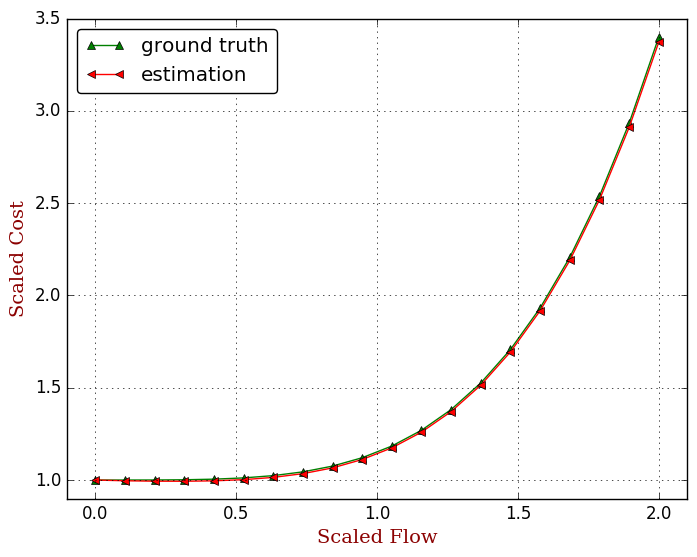

In [18]:
using PyPlot

true_coeffs = [1, 0, 0, 0, .15]
fcoeffs = coeffs_dict[(deg, c, lam)]

xs = linspace(0, 2, 20)
ys_true = map(x->polyEval(true_coeffs, x), xs)
ys = map(x->polyEval(fcoeffs, x), xs)

# ys = map(x->polyEval(fcoeffs, x), xs)

plot(xs, ys_true, "^-g", label="ground truth")
plot(xs, ys, "<-r", label="estimation")

legend(loc="upper left",fancybox="true") 
# plot(xs, ys, "--b")
grid("on")
xlim(-0.1, 2.1);
ylim(0.9, 3.5);

font1 = ["family"=>"serif", "color"=>"darkred", "weight"=>"normal", "size"=>14]
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("./results/fitting_Sioux_inv_multi.pdf")